Loading and preparing data...
Dataset shape: (100621, 21)
Class distribution:
decision_grouped
0    37245
1    35986
2    27390
Name: count, dtype: int64

Checking data quality...
Missing values:
undergrad_gpa                 0
gre_quantitative_reasoning    0
gre_verbal_reasoning          0
analytical_writing            0
dtype: int64

Performing refined feature engineering...
Total features after engineering: 13
Class distribution (binary): binary_decision
0    64635
1    35986
Name: count, dtype: int64
Class imbalance ratio (rejected:admitted): 1.80:1
Numeric features: 12
Categorical features: 1

Setting up enhanced preprocessing pipeline...

Training baseline models...
XGBoost Baseline - Accuracy: 0.6542, F1 Score: 0.3296
              precision    recall  f1-score   support

           0       0.68      0.89      0.77     12928
           1       0.54      0.24      0.33      7197

    accuracy                           0.65     20125
   macro avg       0.61      0.56      0.55    

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:50:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:50:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:50:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:50:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Best parameters: {'classifier__colsample_bytree': 0.9, 'classifier__gamma': 0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}

Training Random Forest with balanced class weights...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best RF parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Evaluating best models...

Best XGBoost Model - Accuracy: 0.5768, F1 Score: 0.5144, AUC: 0.6258

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.55      0.62     12928
           1       0.44      0.63      0.51      7197

    accuracy                           0.58     20125
   macro avg       0.58      0.59      0.57     20125
weighted avg       0.62      0.58      0.59     20125


Best Random Forest Model - Accura

<Figure size 1200x600 with 0 Axes>

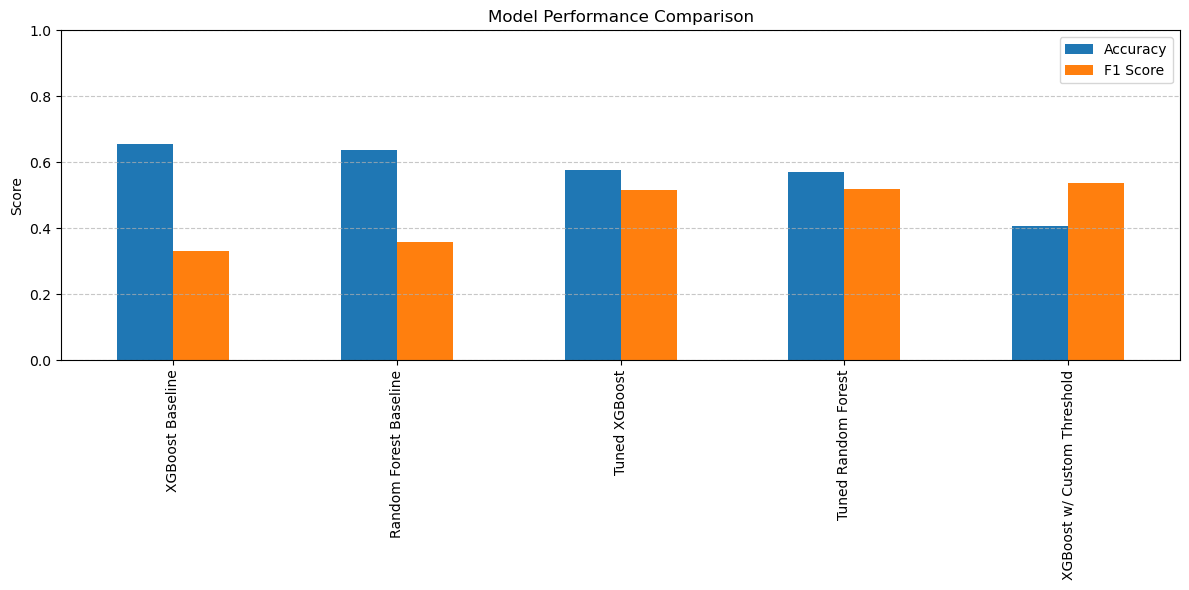


Analyzing feature importance...


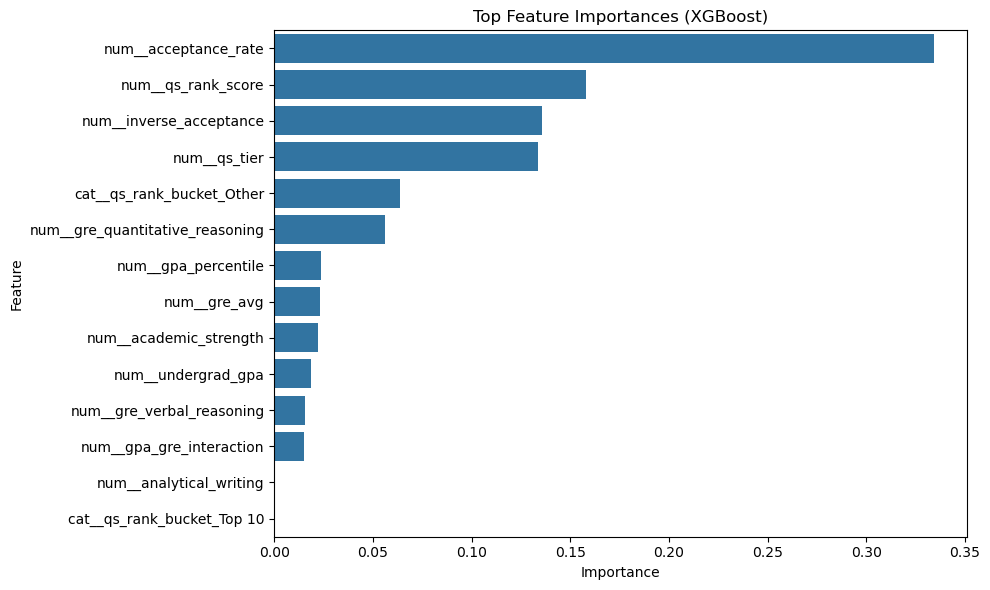


Top 15 important features:
                            Feature  Importance
4              num__acceptance_rate    0.334610
5                num__qs_rank_score    0.158039
10          num__inverse_acceptance    0.135691
6                      num__qs_tier    0.133564
12        cat__qs_rank_bucket_Other    0.063589
1   num__gre_quantitative_reasoning    0.056164
8               num__gpa_percentile    0.023576
7                      num__gre_avg    0.023198
11           num__academic_strength    0.022374
0                num__undergrad_gpa    0.018533
2         num__gre_verbal_reasoning    0.015770
9          num__gpa_gre_interaction    0.014895
3           num__analytical_writing    0.000000
13       cat__qs_rank_bucket_Top 10    0.000000


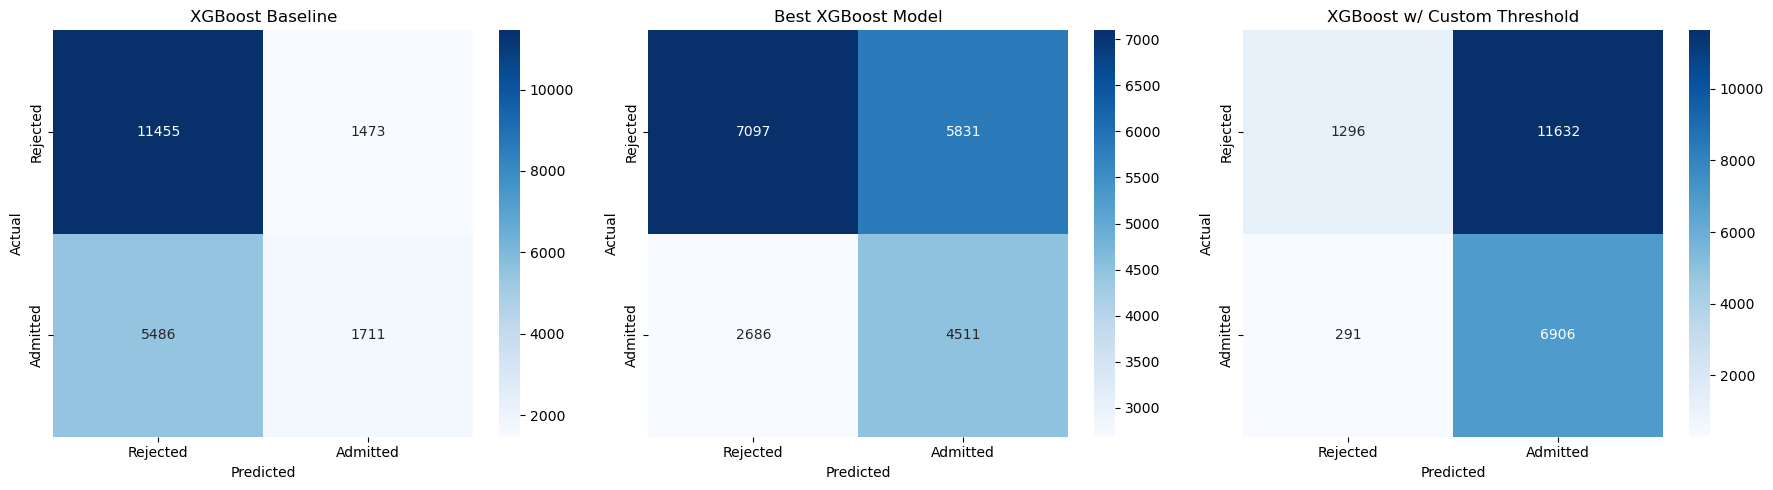


Saving best model...
Best model by F1 score: XGBoost w/ Custom Threshold
Model saved with optimal threshold: 0.40

Creating prediction function...

Example of prediction function usage:
new_student = pd.DataFrame({'undergrad_gpa': [3.9], 'gre_quantitative_reasoning': [167], ...})
result = predict_admission_chance(best_model, new_student, threshold=optimal_threshold)
print(f"Admission probability: {result['admission_probability'][0]:.2f}")


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load dataset
print("Loading and preparing data...")
df = pd.read_excel('../data/processed/exploratory_analysis_final.xlsx', sheet_name='Sheet1')

print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['decision_grouped'].value_counts()}")

# --- Data Quality Check ---
print("\nChecking data quality...")
print(f"Missing values:\n{df[['undergrad_gpa', 'gre_quantitative_reasoning', 'gre_verbal_reasoning', 'analytical_writing']].isnull().sum()}")

# --- More refined feature engineering ---
print("\nPerforming refined feature engineering...")

# Handle missing values in key columns with more sophisticated imputation
for col in ['undergrad_gpa', 'gre_quantitative_reasoning', 'gre_verbal_reasoning', 
            'analytical_writing', 'acceptance_rate', 'qs_rank_score']:
    if col in df.columns:
        # For now we'll use median, but KNN imputation is used in the pipeline
        median = df[col].median()
        df[col] = df[col].fillna(median)

# Calculate or use existing basic features
if 'gre_avg' not in df.columns:
    df['gre_avg'] = (df['gre_quantitative_reasoning'] + df['gre_verbal_reasoning']) / 2
    
if 'gpa_percentile' not in df.columns:
    df['gpa_percentile'] = df['undergrad_gpa'].rank(pct=True)

# Strong predictive interactions based on domain knowledge
df['gpa_gre_interaction'] = df['undergrad_gpa'] * df['gre_avg']
df['inverse_acceptance'] = 1 / (df['acceptance_rate'] + 0.001)  # Adding small constant to avoid division by zero

# Academic strength composite score (normalized)
df['academic_strength'] = (
    (df['undergrad_gpa'] / df['undergrad_gpa'].max()) * 0.5 +
    (df['gre_avg'] / df['gre_avg'].max()) * 0.3 +
    (df['analytical_writing'] / df['analytical_writing'].max()) * 0.2
)

# Rank bucketing - refined version
def rank_bucket(score):
    if pd.isna(score):
        return 'Unknown'
    elif score <= -10:
        return 'Top 10'
    elif score <= -30:
        return 'Top 30'
    elif score <= -50:
        return 'Top 50'
    elif score <= -100:
        return 'Top 100'
    else:
        return 'Other'

df['qs_rank_bucket'] = df['qs_rank_score'].apply(rank_bucket)

# Feature list - refined based on domain knowledge and previous importance
features = [
    # Core academic metrics
    'undergrad_gpa', 'gre_quantitative_reasoning', 'gre_verbal_reasoning',
    'analytical_writing', 
    # School metrics
    'acceptance_rate', 'qs_rank_score', 'qs_tier',
    # Derived features
    'gre_avg', 'gpa_percentile', 'gpa_gre_interaction',
    'inverse_acceptance', 'qs_rank_bucket', 'academic_strength'
]

# Remove any features that don't exist in the dataframe
features = [f for f in features if f in df.columns]
print(f"Total features after engineering: {len(features)}")

# Create binary target: 1 if admitted, 0 otherwise
df['binary_decision'] = df['decision_grouped'].apply(lambda x: 1 if x == 1 else 0)

# Check for class imbalance
class_counts = df['binary_decision'].value_counts()
print(f"Class distribution (binary): {class_counts}")
imbalance_ratio = class_counts[0] / class_counts[1]
print(f"Class imbalance ratio (rejected:admitted): {imbalance_ratio:.2f}:1")

X = df[features]
y = df['binary_decision']

# Split data with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# --- Enhanced preprocessing pipeline ---
print("\nSetting up enhanced preprocessing pipeline...")

# Using KNN imputation for better missing value handling
numeric_transformer = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('power', PowerTransformer(standardize=True))  # Better handles skewed features
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# --- Train baseline models to compare ---
print("\nTraining baseline models...")

# Original XGBoost baseline
xgb_baseline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

xgb_baseline.fit(X_train, y_train)
xgb_baseline_preds = xgb_baseline.predict(X_test)
xgb_baseline_acc = accuracy_score(y_test, xgb_baseline_preds)
xgb_baseline_f1 = f1_score(y_test, xgb_baseline_preds)

print(f"XGBoost Baseline - Accuracy: {xgb_baseline_acc:.4f}, F1 Score: {xgb_baseline_f1:.4f}")
print(classification_report(y_test, xgb_baseline_preds))

# Random Forest baseline
rf_baseline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_baseline.fit(X_train, y_train)
rf_baseline_preds = rf_baseline.predict(X_test)
rf_baseline_acc = accuracy_score(y_test, rf_baseline_preds)
rf_baseline_f1 = f1_score(y_test, rf_baseline_preds)

print(f"Random Forest Baseline - Accuracy: {rf_baseline_acc:.4f}, F1 Score: {rf_baseline_f1:.4f}")
print(classification_report(y_test, rf_baseline_preds))

# --- XGBoost with balanced class weights and refined parameters ---
print("\nTraining XGBoost with balanced class weights...")

# Class balancing weight calculation 
scale_pos_weight = class_counts[0] / class_counts[1]

# More nuanced tuning strategy for XGBoost
xgb_balanced = XGBClassifier(
    random_state=42,
    use_label_encoder=False, 
    eval_metric='auc',  # Changed to AUC which is better for imbalanced data
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic'
)

# More focused parameter grid based on model knowledge
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 2],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0, 0.1]
}

# Setting up XGBoost pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb_balanced)
])

# Grid search with cross-validation
print("\nPerforming grid search with cross-validation...")
grid_search = GridSearchCV(
    xgb_pipeline,
    {'classifier__' + k: v for k, v in param_grid.items()},
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # Stratified CV for imbalanced data
    scoring='f1',  # Focus on balanced performance
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")

# --- Random Forest with balanced class weights ---
print("\nTraining Random Forest with balanced class weights...")
rf_balanced = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',  # Use balanced class weights
    n_jobs=-1
)

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf_balanced)
])

rf_grid_search = GridSearchCV(
    rf_pipeline,
    {'classifier__' + k: v for k, v in rf_param_grid.items()},
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

rf_grid_search.fit(X_train, y_train)
print(f"Best RF parameters: {rf_grid_search.best_params_}")

# --- Evaluate best models ---
print("\nEvaluating best models...")

# Evaluate XGBoost model
best_xgb = grid_search.best_estimator_
xgb_preds = best_xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_preds)
xgb_f1 = f1_score(y_test, xgb_preds)
xgb_proba = best_xgb.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_proba)

print(f"\nBest XGBoost Model - Accuracy: {xgb_accuracy:.4f}, F1 Score: {xgb_f1:.4f}, AUC: {xgb_auc:.4f}")
print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_preds))

# Evaluate Random Forest model
best_rf = rf_grid_search.best_estimator_
rf_preds = best_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)
rf_proba = best_rf.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_proba)

print(f"\nBest Random Forest Model - Accuracy: {rf_accuracy:.4f}, F1 Score: {rf_f1:.4f}, AUC: {rf_auc:.4f}")
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_preds))

# --- Custom threshold tuning for probability cutoff ---
print("\nTuning decision threshold for better balance...")

# Find optimal threshold for XGBoost
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for threshold in thresholds:
    custom_preds = (xgb_proba >= threshold).astype(int)
    f1 = f1_score(y_test, custom_preds)
    f1_scores.append(f1)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.2f}, F1 Score: {f1_scores[optimal_idx]:.4f}")

# Apply optimal threshold
custom_preds = (xgb_proba >= optimal_threshold).astype(int)
custom_accuracy = accuracy_score(y_test, custom_preds)
custom_f1 = f1_score(y_test, custom_preds)

print(f"\nXGBoost with optimal threshold - Accuracy: {custom_accuracy:.4f}, F1 Score: {custom_f1:.4f}")
print("\nCustom Threshold Classification Report:")
print(classification_report(y_test, custom_preds))

# --- Select best model ---
models = {
    "XGBoost Baseline": {"accuracy": xgb_baseline_acc, "f1": xgb_baseline_f1},
    "Random Forest Baseline": {"accuracy": rf_baseline_acc, "f1": rf_baseline_f1},
    "Tuned XGBoost": {"accuracy": xgb_accuracy, "f1": xgb_f1, "auc": xgb_auc},
    "Tuned Random Forest": {"accuracy": rf_accuracy, "f1": rf_f1, "auc": rf_auc},
    "XGBoost w/ Custom Threshold": {"accuracy": custom_accuracy, "f1": custom_f1}
}

# Create model comparison dataframe
model_compare = pd.DataFrame({
    "Accuracy": [models[m]["accuracy"] for m in models],
    "F1 Score": [models[m]["f1"] for m in models],
    "AUC": [models[m].get("auc", np.nan) for m in models]
}, index=models.keys())

print("\nModel Comparison:")
print(model_compare)

# Plot model comparison
plt.figure(figsize=(12, 6))
model_compare[["Accuracy", "F1 Score"]].plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Feature Importance Analysis ---
print("\nAnalyzing feature importance...")

# Get XGBoost feature importances
if hasattr(best_xgb[-1], 'feature_importances_'):
    # Get feature names after preprocessing
    if hasattr(preprocessor, 'get_feature_names_out'):
        try:
            feature_names = preprocessor.get_feature_names_out()
        except:
            # Fallback for compatibility
            feature_names = [f"feature_{i}" for i in range(len(best_xgb[-1].feature_importances_))]
    else:
        feature_names = [f"feature_{i}" for i in range(len(best_xgb[-1].feature_importances_))]
    
    # Create importance dataframe
    importances = best_xgb[-1].feature_importances_
    n_features = min(len(feature_names), len(importances))
    feature_importance = pd.DataFrame({
        'Feature': feature_names[:n_features],
        'Importance': importances[:n_features]
    }).sort_values(by='Importance', ascending=False)
    
    # Plot top features
    plt.figure(figsize=(10, 6))
    top_n = min(15, len(feature_importance))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(top_n))
    plt.title('Top Feature Importances (XGBoost)')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 15 important features:")
    print(feature_importance.head(15))

# --- Confusion Matrix Comparison ---
# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# XGBoost baseline
cm1 = confusion_matrix(y_test, xgb_baseline_preds)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Rejected', 'Admitted'],
            yticklabels=['Rejected', 'Admitted'], ax=axes[0])
axes[0].set_title('XGBoost Baseline')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Best XGBoost model
cm2 = confusion_matrix(y_test, xgb_preds)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Rejected', 'Admitted'],
            yticklabels=['Rejected', 'Admitted'], ax=axes[1])
axes[1].set_title('Best XGBoost Model')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Custom threshold model
cm3 = confusion_matrix(y_test, custom_preds)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Rejected', 'Admitted'],
            yticklabels=['Rejected', 'Admitted'], ax=axes[2])
axes[2].set_title('XGBoost w/ Custom Threshold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# --- Save the best performing model ---
print("\nSaving best model...")

# Determine best model based on F1 score
best_model_name = model_compare['F1 Score'].idxmax()
print(f"Best model by F1 score: {best_model_name}")

# Set the best model based on the name
if best_model_name == "Tuned XGBoost":
    best_model = best_xgb
elif best_model_name == "Tuned Random Forest":
    best_model = best_rf
elif best_model_name == "XGBoost w/ Custom Threshold":
    # For custom threshold, we need to create a custom pipeline with threshold
    class ThresholdClassifier:
        def __init__(self, base_model, threshold=0.5):
            self.base_model = base_model
            self.threshold = threshold
            
        def fit(self, X, y):
            self.base_model.fit(X, y)
            return self
            
        def predict(self, X):
            return (self.base_model.predict_proba(X)[:, 1] >= self.threshold).astype(int)
            
        def predict_proba(self, X):
            return self.base_model.predict_proba(X)
    
    # Use XGBoost with custom threshold
    thresholded_model = ThresholdClassifier(best_xgb, threshold=optimal_threshold)
    
    # This is just for saving, but we'll use best_xgb with adjusted threshold in practice
    best_model = best_xgb
else:
    # Default to XGBoost baseline
    best_model = xgb_baseline

import pickle
with open('refined_grad_admission_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

if best_model_name == "XGBoost w/ Custom Threshold":
    # Save the optimal threshold separately
    with open('optimal_threshold.pkl', 'wb') as f:
        pickle.dump(optimal_threshold, f)
    print(f"Model saved with optimal threshold: {optimal_threshold:.2f}")
else:
    print("Model saved successfully")

# --- Create prediction function ---
print("\nCreating prediction function...")

def predict_admission_chance(model, student_data, threshold=0.5):
    """
    Predict admission probability for new student data.
    
    Parameters:
    -----------
    model : Pipeline
        Trained model pipeline
    student_data : DataFrame
        New student data with required features
    threshold : float
        Custom probability threshold for binary prediction
        
    Returns:
    --------
    DataFrame with original data plus prediction results
    """
    # Ensure required features are present
    expected_features = features
    missing_features = [f for f in expected_features if f not in student_data.columns]
    
    # Handle missing features
    if missing_features:
        print(f"Warning: Missing features: {missing_features}")
        for feat in missing_features:
            student_data[feat] = np.nan  # Will be handled by imputer
    
    # Only use the expected features
    data_for_pred = student_data[expected_features].copy()
    
    # Make prediction
    pred_proba = model.predict_proba(data_for_pred)[:, 1] if hasattr(model, 'predict_proba') else None
    if pred_proba is not None:
        pred_class = (pred_proba >= threshold).astype(int)
    else:
        pred_class = model.predict(data_for_pred)
    
    # Add results to dataframe
    result = student_data.copy()
    if pred_proba is not None:
        result['admission_probability'] = pred_proba
    result['predicted_decision'] = pred_class
    result['predicted_result'] = result['predicted_decision'].map({1: 'Admitted', 0: 'Rejected'})
    
    return result

print("\nExample of prediction function usage:")
print("new_student = pd.DataFrame({'undergrad_gpa': [3.9], 'gre_quantitative_reasoning': [167], ...})")
print("result = predict_admission_chance(best_model, new_student, threshold=optimal_threshold)")
print("print(f\"Admission probability: {result['admission_probability'][0]:.2f}\")")